# Introduction To Astro-Data Analysis

In this notebook, I will cover the key methods required to get started with processing astrophysical datasets.

We will cover:
- Downloading datasets directly from the source using scripts
- Dealing with different file formats
- Loading in data effectively
- Processing and manipulating data
- Visulation
- Storing Data

## Case Study
Gamma-Ray Bursts (GRBs) are among the highest energy events that arise within the Universe. They can outshine galaxies and can be seen at extremely high redshift. There are two primary classes of GRBs, short and long. These are characterised by the time taken for 5\% - 95\% of the flux to be detected (T90). Short GRBs have T90s typically <2 s, whilst for Long GRBs, the T90s are >2 s.  

In this example, we will:
- Download some GRB light curves
- Visualise
- Download and visualise location skymaps corresponding to the GRB
- Identify the nearest galaxies
- Circle regions of interest
- Output a list of nearby galaxies

## Downloading data


In [177]:
"""Conveniently, python has native packages that can help us download data directly from HTTP sources! 
The [urlretrieve] package is what we will be using to download the dataset that we are interested in."""
import urllib.request as req
import shutil #for shell operations
"Download the data for GRB 211211A - Full list can be found here: https://www.swift.ac.uk/xrt_products/index.php?year=2022"
"Click on the curve option for the GRB of interest and click the download button. You can either save the file directly or copy the url."
GRB = 'GRB211211A'
"Direct Download"
url  = "https://www.swift.ac.uk/scripts/viewData.php?file=https://www.swift.ac.uk/user_objects/tprods/tmp_jsplot_RgjInW.qdp"
"Note: You may need to get a new link if the URL provided does not work. Check the Swift link noted above."
text_file = '{}_xrt.txt'.format(GRB)
try:
    data = req.urlretrieve(url,text_file) #Legacy method
except:
    print("Legacy method has failed")
    "Modern approach to downloading datasets"
    with req.urlopen(url) as response, open(text_file,'wb') as of:
        shutil.copyfileobj(response,of)
"Let's preview the file"
f=open(text_file,'r') #opens the file
print(f.read(1000)) #reads the first 100 characters
f.close() #closes the file


READ TERR 1 2
! WTSLEW
69.9743357492305	0.306271252653971	-0.627777791207436	6.78875744702424e-08	6.70027921276708e-09	-6.66919272114592e-09
70.885004784499	0.487963190743571	-0.604397782614527	5.35267896547529e-08	5.30773676222583e-09	-5.30095445235233e-09
71.8514489319465	0.526729085295955	-0.478480956703848	6.07191123146501e-08	6.02363112725272e-09	-6.01461100192462e-09
73.0492055230983	0.617135440845203	-0.671027505855889	4.77109292899582e-08	4.74432085142327e-09	-4.7325332779053e-09
74.1514555612188	0.61080238919007	-0.485114597275341	5.65116292099323e-08	5.61720752794371e-09	-5.61992247880915e-09
75.3647542483539	0.619742719541634	-0.602496297944953	4.95491660514466e-08	4.99546134007864e-09	-6.11798938573008e-09
76.6296523856011	0.600222599719899	-0.64515541770561	4.71570807981703e-08	4.83860936275126e-09	-7.69536479830198e-09
78.0657704342574	0.689686490181089	-0.835895448936412	5.15278550750758e-08	4.43569334116616e-09	-5.81480706277939e-09
NO NO NO NO NO NO
! WT
83.302	0.367	-

We can see here that the datafile contains multiple chunks of different datapoints within its tables. This can make loading the file in tricky. However, there are ways to get around this! We will explore these below.

## Loading in dataset
Now that we have downloaded our data, we need to load it in, so we can start processing it! 

In [100]:
import pandas as pd
import numpy as np
import csv

### Using Pandas


In [130]:
"The dataset has 4 headers but 6 columns"
#print('NO '*6)
"""
As our datafile has some oddities, we will be loading it in with settings that allow us to skip inconsistent lines and flag NaNs.
Parameter Description:
1. The first parameter loads in the file corresponding to a string.
2. 'sep' indicates the separation between columns. In this case, each column is separated by a tab.
3. I have skipped the first row as it gives a general header which has inconsistent rows with the rest of the data.
4. Here I have defined my own header names. As I knew what to expect from the data, I was able to name the columns. By
default the headers will be numbers 0-N.
5. I'm telling pandas that my data shouldn't have headers following the processing. This prevents the first data row from being read
in as the header.
6. As the datafile has some section breaks indicated by "!", I have marked lines with these as comments.
7. The data sets in the table are separated by "NO NO NO NO NO NO" (one for each column). Here I have defined these as NaN values.
"""
data_table = pd.read_table(text_file,sep='\t',skiprows=[0,-1],names=["time","terr+","terr-","f","f+","f-"],
                           header=None,comment='!',na_values=[('NO '*6)[:-1]])
data_table.head() #previews the data table
"Note: We could use the NaN values to act as indicators of how the data is segmented."

"For the sake of this tutorial, we will be removing any NaN values and treating the data as one dataset"

print("Table length before NaN removal: {}".format(len(data_table)))
data_table = data_table.dropna(0)
print("Table length after NaN removal: {}".format(len(data_table)))
print(data_table)

"Fix dtype of data_table"
data_table['time'] = data_table['time'].astype(np.float64)

Table length before NaN removal: 290
Table length after NaN removal: 286
                 time          terr+         terr-             f  \
0    69.9743357492305       0.306271     -0.627778  6.788757e-08   
1     70.885004784499       0.487963     -0.604398  5.352679e-08   
2    71.8514489319465       0.526729     -0.478481  6.071911e-08   
3    73.0492055230983       0.617135     -0.671028  4.771093e-08   
4    74.1514555612188       0.610802     -0.485115  5.651163e-08   
..                ...            ...           ...           ...   
283         62273.158     573.024000   -525.174000  1.169543e-12   
284         67663.355     200.306000   -368.858000  1.419150e-12   
285         68100.424     289.764000   -236.763000  1.968949e-12   
286         75209.989    4660.091000  -2061.256000  8.086668e-13   
287        118513.353  167656.747000 -28024.017000  1.453584e-13   

               f+            f-  
0    6.700279e-09 -6.669193e-09  
1    5.307737e-09 -5.300954e-09  
2    6.0

### Visualising the data

'Task: Select the plots after the initial break and give them a different colour.\nIt should mostly resemble - https://www.swift.ac.uk/xrt_curves/01088940/'

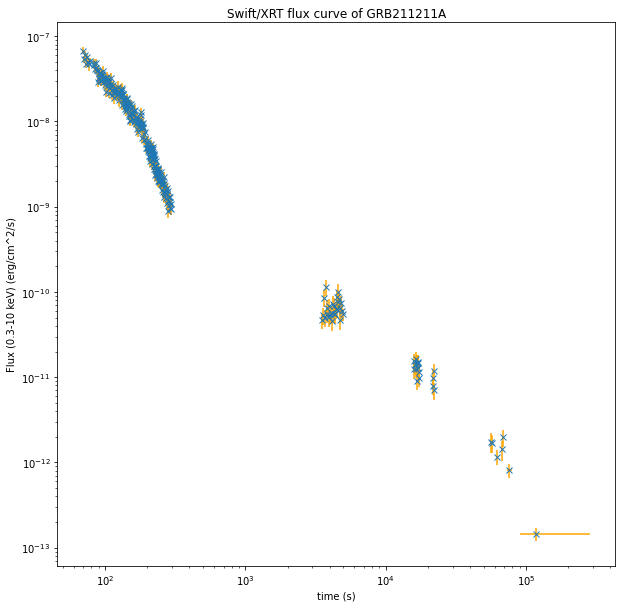

In [167]:
import matplotlib.pyplot as plt #Import the plotting libraries from matplotlib 
fig = plt.figure(1,figsize=(10,10)) #Create a figure space for our plots
ax = fig.add_subplot(111) #Create a plot

"Create a error bars, arguments are x,y, x error, y error, point format, and errorbar color"
ax.errorbar(data_table['time'],data_table['f'],xerr=[-1*data_table['terr-'].values,data_table['terr+'].values]
            ,yerr=[-1*data_table['f-'].values,data_table['f+'].values]
            ,fmt='x',ecolor='orange')
ax.set_xlabel("time (s)") #set x-axis label
ax.set_ylabel("Flux (0.3-10 keV) (erg/cm^2/s)") #set y-axis label
ax.set_title("Swift/XRT flux curve of {}".format(GRB)) #set title
ax.set_xscale("log") #set logscale x
ax.set_yscale("log") #set logscale y
plt.savefig("{}_flux.png".format(GRB),dpi=300) #save the resulting figure


"""Task: Select the plots after the initial break and give them a different colour.
It should mostly resemble - https://www.swift.ac.uk/xrt_curves/01088940/"""

'Bonus Task (not part of the homework): Find a way to autonomously highlight the nearby galaxies.'

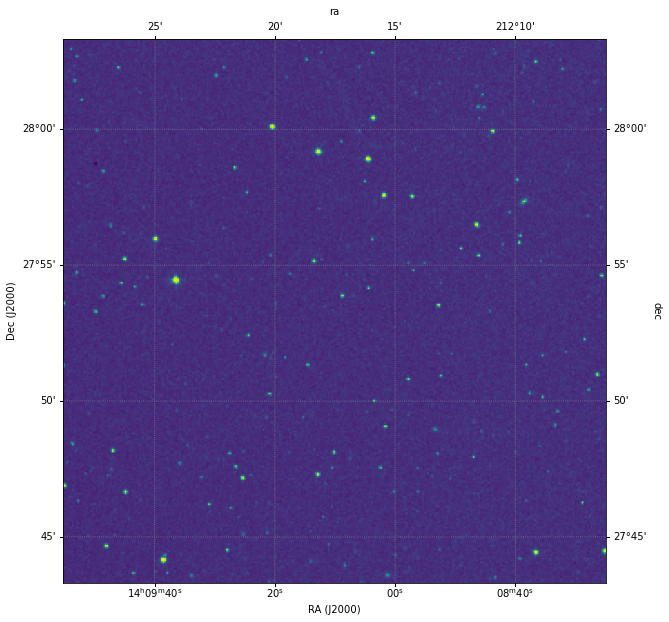

In [178]:
"If astroquery is not installed, uncomment the following"
"""
try:
    !conda install astroquery
except:
    !pip install astroquery
finally:
    pass
"""
from astroquery.skyview import SkyView #Import SkyView Library
import astropy.units as u #Import astropy units 
from astropy.wcs import WCS #Import World Coordinate System

"Download fits file of the skymap around the GRB"
"""This method downloads the skymap for a given position (either by designator or astropy coordinates).
The size of the skymap downloaded is dictated by the specified radius."""
field_info = SkyView.get_images(position=GRB,survey=['DSS'],radius=20*u.arcmin,coordinates='J2000')
img_data= field_info[0][0].data #Extract the image information from the fits file
wcs = WCS(field_info[0][0].header) #Extract the WCS information from the fits file
fig = plt.figure(1,figsize=(10,10)) #Create a figure space for our plots
ax = fig.add_subplot(111,projection=wcs) #Create a plot
ax.imshow(img_data) #Visualise the image data - Note: Play around with the arguments to alter the visualisation - check docs.
ax.set_xlabel('RA (J2000)') 
ax.set_ylabel('Dec (J2000)')
overlay = ax.get_coords_overlay('fk5') #Overlay coordinates
overlay.grid(color='grey',ls='dotted')
"""
Homework Tasks:
1. Play with the colour maps, look up the documentation for plt.imshow to figure out how.
2. Highlight the location of the GRB by plotting a scatter point at the location (RA:14h 09m 10.08s, Dec +27° 53′ 18.8′′)
3. Create an inset plot in the top right corner of the spectrum which points to the location of the GRB.
4. Save the figure and email it to me before 5pm on Friday 3rd March. The best visualisation will recieve a prize.
"""

"Bonus Task (not part of the homework): Find a way to autonomously highlight the nearby galaxies."